<a href="https://colab.research.google.com/github/pharringtonp19/business-analytics/blob/main/notebooks/distributions_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **References**

- https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

### **Install Libraries**

In [19]:
!pip install oryx

### **Import Functions**

In [20]:
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
from jax import random

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import oryx
from oryx.core.ppl import random_variable
from oryx.core.ppl import log_prob
from oryx.core.ppl import joint_sample
from oryx.core.ppl import joint_log_prob
from oryx.core.ppl import block
from oryx.core.ppl import intervene
from oryx.core.ppl import conditional
from oryx.core.ppl import graph_replace
from oryx.core.ppl import nest

## **Normal Random Variable**

In [21]:
def X(p, key1, key2):
  question = random_variable(tfd.Uniform(0., 1.))(key1)
  delta = random_variable(tfd.Uniform(-0.25, 0.25))(key2)
  return (question < p + delta).astype(jnp.float32)

p = 0.8
X(p, jax.random.PRNGKey(0), jax.random.PRNGKey(1))

Array(1., dtype=float32)

### **Creating a Bunch of Keys**

In [22]:
key = jax.random.PRNGKey(0)
k1, k2 = jax.random.split(key)
a_bunch_of_keys = jax.random.split(k1, 50_000)
b_bunch_of_keys = jax.random.split(k2, 50_000)

### **Evaluating the Random Variable Across a bunch of Keys**

In [23]:
ys = jax.vmap(partial(X, 0.8))(a_bunch_of_keys, b_bunch_of_keys)

### **Plotting**

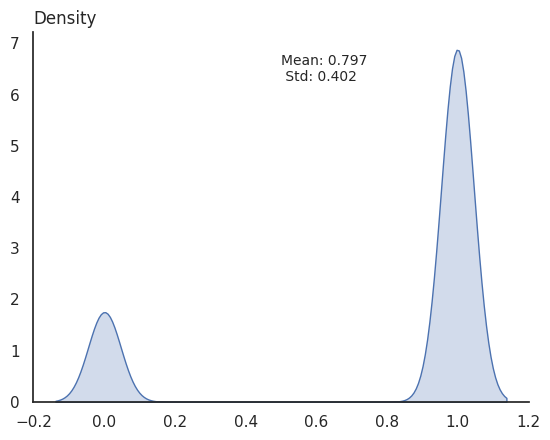

In [24]:
sns.kdeplot(ys, fill=True)
plt.ylabel('')
plt.title('Density', loc='left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.annotate(f'Mean: {jnp.mean(ys):.3f}\n Std: {jnp.std(ys):.3f}',
            xy = (.5, .9),
            xycoords='axes fraction',
            ha='left',
            va="center",
            size=10)

plt.show()

## **Sample Mean (i.i.d)**

In [49]:
def SampleMean_iid(p, n, key):
  k1, k2 = jax.random.split(key, 2)
  k1s = jax.random.split(k1, n)
  k2s = jax.random.split(k2, n)
  ys = jax.vmap(partial(X, p))(k1s, k2s)
  return jnp.mean(ys)

def SampleMean_cluster(p, n, key):
  k1, k2 = jax.random.split(key, 2)
  k1s = jax.random.split(k1, n)
  k2s = jnp.tile(key, (n, 1))
  ys = jax.vmap(partial(X, p))(k1s, k2s)
  return jnp.mean(ys)

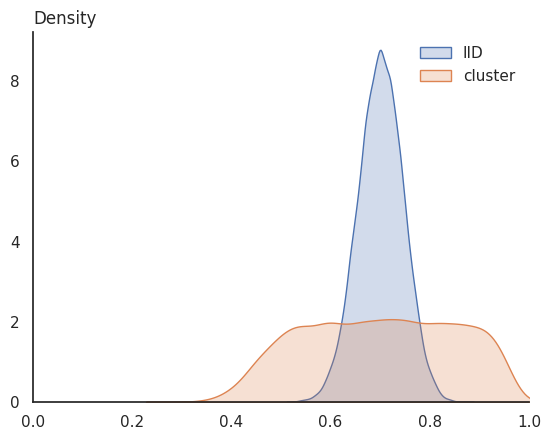

In [58]:
p = 0.7
n = 100

a_bunch_of_keys = jax.random.split(jax.random.PRNGKey(0), 20_000)
ys_iid = jax.vmap(partial(SampleMean_iid, p, n))(a_bunch_of_keys)
ys_cluster = jax.vmap(partial(SampleMean_cluster, p, n))(a_bunch_of_keys)


sns.kdeplot(ys_iid, fill=True, label='IID')
sns.kdeplot(ys_cluster, fill=True, label='cluster')
plt.ylabel('')
plt.title('Density', loc='left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim(0, 1)
plt.legend(frameon=False)
plt.show()